## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
#import xgboost as xgb
#from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
# check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [3]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [4]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [5]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [6]:
test_data['Promotion'].value_counts()

No     20902
Yes    20748
Name: Promotion, dtype: int64

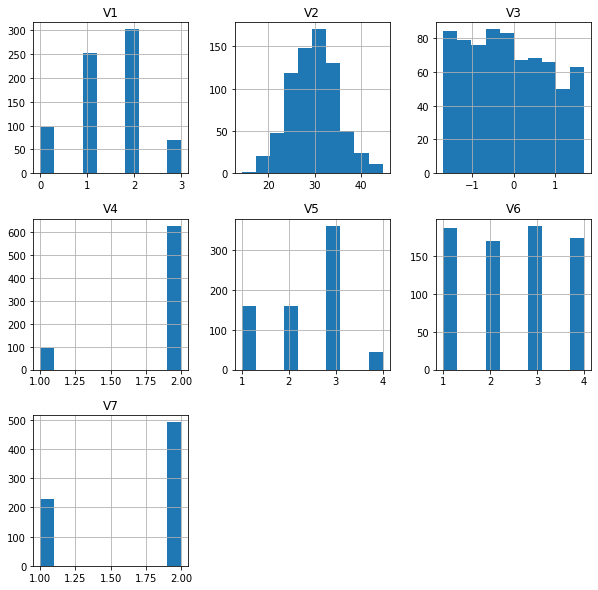

In [7]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

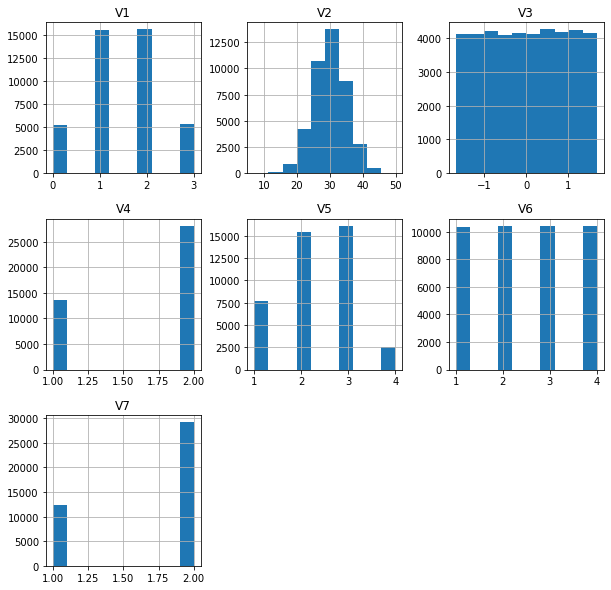

In [8]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

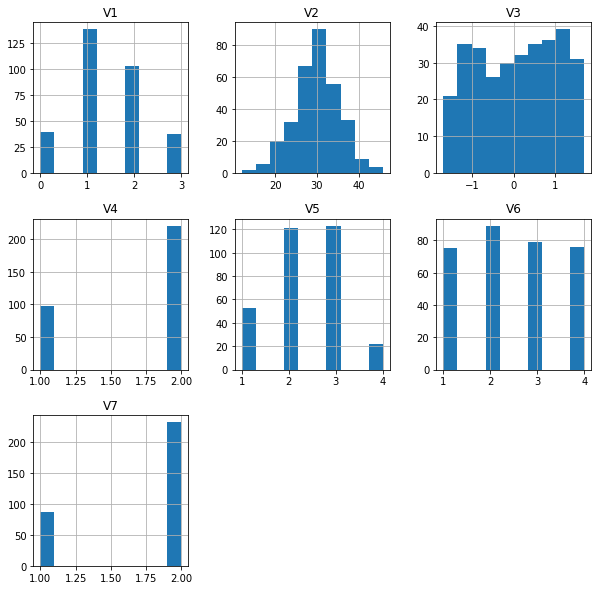

In [9]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

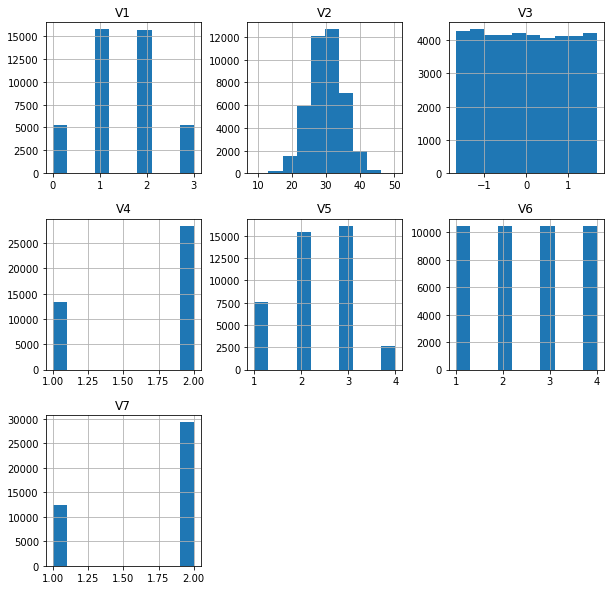

In [10]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

In [11]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    
    
    return promotion

In [12]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [13]:
# Check sample size needed for control and treatment groups
NormalIndPower().solve_power(effect_size = proportion_effectsize(.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

If we were to send everyone a promotion, our IRR is 0.96\% and NIR is -\$1,132.20. This will be the baseline model. Hence, blindly sending everyone a promotion is going to lose the company a lot of money.

Our baseline IRR is 0.096\%. If our desired minimum IRR is 1.5\% (an 0.081\% absolute increase in IRR), and we want to detect this change with a type 1 error rate of 0.05 and a power of 0.80, we will need a sample size of approximately 5,090 in each group (both control and treatment). Since, we have more than 40,000 data points in each group, we have sufficient data

### Model : Predict only for indivduals who received promotions and purchased

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. This is a simple model that surprisingly performed relatively well for this dataset, generating an incremental response rate (irr) of 2.19\% and a net incrmental revenue (nlr) of 332.70dollars. 
This actually outperformed the Starbuck's model for this dataset, which was an irr of 1.88\% and an nlr of $189.45. 

However, since the irr and nlr on the validation set is lower at 1.93% and 94.70$,the model's relatively good performance on the test set may be due to random chance. Overall, it still performed superbly for such a simple model.

In [14]:
# read data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [15]:
train_data.iterrows

<bound method DataFrame.iterrows of            ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0           1        No         0   2  30.443518 -1.165083   1   1   3   2
1           3        No         0   3  32.159350 -0.645617   2   3   2   2
2           4        No         0   2  30.431659  0.133583   1   1   4   2
3           5        No         0   0  26.588914 -0.212728   2   1   4   2
4           8       Yes         0   3  28.044332 -0.385883   1   1   2   2
...       ...       ...       ...  ..        ...       ...  ..  ..  ..  ..
84529  126180        No         0   1  30.084876  1.345672   1   1   3   1
84530  126181       Yes         0   3  33.501485 -0.299306   1   1   4   1
84531  126182        No         0   1  31.492019  1.085939   2   3   2   2
84532  126183        No         0   1  37.766106  0.999361   2   2   1   2
84533  126184        No         0   1  21.720835  1.085939   2   2   1   2

[84534 rows x 10 columns]>

In [16]:

# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [17]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [18]:
# split data into train and valid
from sklearn import model_selection

train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [34]:
train

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
66588,99250,Yes,0,3,34.470493,-1.078506,1,1,1,2,0.0
62125,92564,No,0,1,28.065819,-1.165083,1,1,3,1,0.0
27827,41307,Yes,0,1,27.142590,-1.511395,1,3,3,2,0.0
66648,99341,Yes,0,3,28.782344,-1.078506,1,1,1,2,0.0
47392,70517,No,0,2,39.605508,-0.645617,2,3,1,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6265,9347,No,0,1,25.513060,-0.126150,1,2,3,2,0.0
54886,81802,No,0,3,31.485170,0.047006,1,2,2,2,0.0
76820,114665,No,0,1,28.643406,0.653050,2,1,1,2,0.0
860,1277,No,0,2,21.724511,1.085939,1,3,3,2,0.0


In [33]:
valid

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
6264,9346,Yes,0,3,18.012754,-1.511395,2,2,4,1,0.0
41822,62172,No,0,2,28.676557,-0.126150,2,3,3,2,0.0
8569,12768,No,0,0,28.817748,-1.511395,2,4,3,2,0.0
41228,61264,No,0,1,26.140783,-0.905350,2,1,4,2,0.0
24896,37024,Yes,0,1,32.346423,0.566472,1,2,3,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31179,46300,Yes,0,3,26.310883,-0.299306,1,3,1,1,0.0
17641,26264,Yes,0,2,24.402187,-1.078506,2,2,4,2,0.0
73097,109020,Yes,0,1,29.043276,1.518828,2,3,1,2,0.0
71261,106302,Yes,0,1,27.070219,-1.597972,2,3,3,2,0.0


In [19]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [23]:
import xgboost as xgb

In [37]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=100)

[0]	validation_0-auc:0.891992	validation_1-auc:0.645481
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.898054	validation_1-auc:0.653202
[2]	validation_0-auc:0.906917	validation_1-auc:0.65697
[3]	validation_0-auc:0.915775	validation_1-auc:0.658408
[4]	validation_0-auc:0.934996	validation_1-auc:0.655914
[5]	validation_0-auc:0.935649	validation_1-auc:0.651876
[6]	validation_0-auc:0.935016	validation_1-auc:0.654039
[7]	validation_0-auc:0.943776	validation_1-auc:0.655699
[8]	validation_0-auc:0.944752	validation_1-auc:0.650929
[9]	validation_0-auc:0.950239	validation_1-auc:0.648446
[10]	validation_0-auc:0.950787	validation_1-auc:0.648789
[11]	validation_0-auc:0.957777	validation_1-auc:0.648527
[12]	validation_0-auc:0.959635	validation_1-auc:0.645952
[13]	validation_0-auc:0.961191	validation_1-auc:0.644991
[14]	validation_0-auc:0.963264	validation_1-auc:0.64435

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

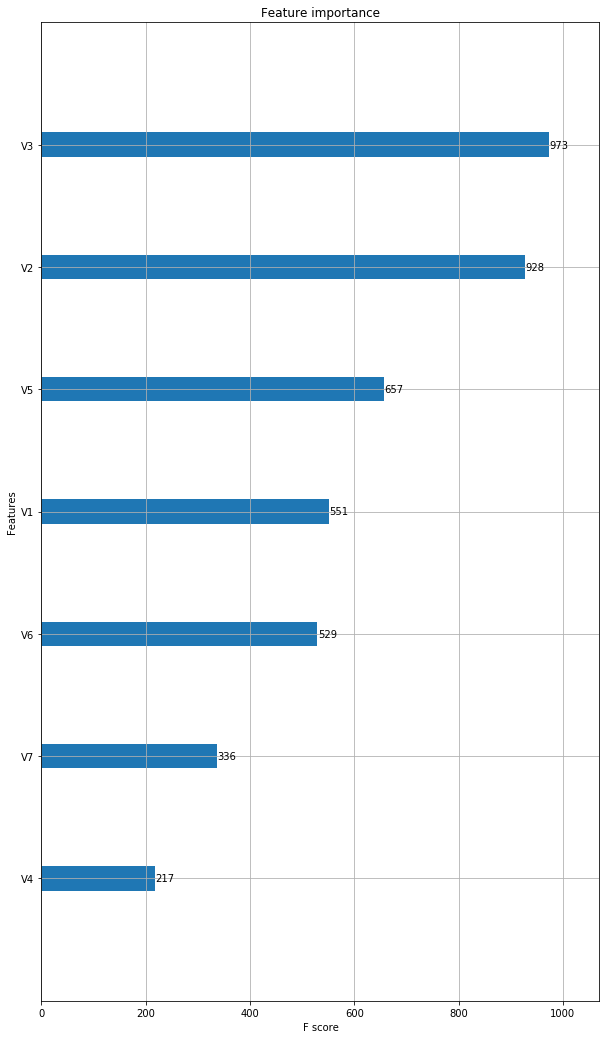

In [39]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [40]:
# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12684,  4082],
       [   83,    58]], dtype=int64)

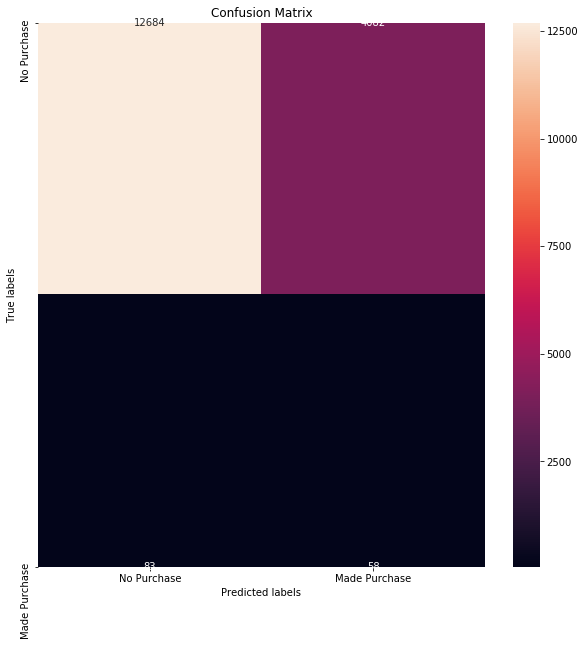

In [41]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [42]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [44]:
from test_results import test_results, score

In [43]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0219.

Your nir with this strategy is 332.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02185148545762388, 332.70000000000005)